# Libererías necesarias

In [43]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import fasttext
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from sklearn.decomposition import PCA
import numpy as np
import sys
import umap
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import hdbscan
from sklearn.preprocessing import StandardScaler

Primero importamos el dataset que hemos limpiado con la función anteriormente creada

In [22]:
with open("../data/cleaned_data/cleaned_arab_quran.txt", encoding="utf-8") as f:
    lines_ar = f.readlines()

df_ar = pd.DataFrame(lines_ar, columns=["text"])
df_ar["text"] = df_ar["text"].str.strip()

df_ar.head()

,text
0,1|1|بسم الله الرحمن الرحيم
1,1|2|الحمد لله رب العالمين
2,1|3|الرحمن الرحيم
3,1|4|مالك يوم الدين
4,1|5|اياك نعبد واياك نستعين


In [23]:
with open("../data/cleaned_data/cleaned_english_quran.txt", encoding="utf-8") as f:
    lines_eng = f.readlines()

df_eng = pd.DataFrame(lines_eng, columns=["text"])
df_eng["text"] = df_eng["text"].str.strip()

df_eng.head()

,text
0,in the name of allah the entirely merciful the...
1,all praise is due to allah lord of the worlds
2,the entirely merciful the especially merciful
3,sovereign of the day of recompense
4,it is you we worship and you we ask for help


# Creación de los modelos

Ahora vamos a usar varios modelos diferentes para comparar los resultados, usaremos el concepto "الجنة" (paraíso) para ambas.

In [14]:
concept = "الجنة"

## Sentence-Transformer Árabe

Importamos el sentence-transformer que vamos a usar para ambos idiomas, ya que éste es multilingüe.

In [24]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v2', device="cpu")

df_st = pd.DataFrame(lines_ar, columns=["text"])
df_st["text"] = df_st["text"].str.strip()
df_st = df_st[df_st["text"].str.contains(r"[\u0600-\u06FF]")]
df_st["arab_embeddings"] = df_st["text"].apply(lambda x: model.encode(x, convert_to_tensor=True))

concept_emb = model.encode(concept, convert_to_tensor=True)

df_st["cos_similarity"] = df_st["arab_embeddings"].apply(lambda x: util.pytorch_cos_sim(x, concept_emb).item())

df_st_sorted = df_st.sort_values(by="cos_similarity", ascending=False)
print("\nTop 10 Sentence-Transformers:")
print(df_st_sorted[["text", "cos_similarity"]].head(10))

# model.save("../src/modelos/sentence_transformers_arabe_busqueda_semantica")


Top 10 Sentence-Transformers:
                                                   text  cos_similarity
4408  43|84|وهو الذي في السماء اله وفي الارض اله ۚ و...        0.401655
5884       84|1|بسم الله الرحمن الرحيم اذا السماء انشقت        0.397278
5829      82|1|بسم الله الرحمن الرحيم اذا السماء انفطرت        0.378910
5909     85|1|بسم الله الرحمن الرحيم والسماء ذات البروج        0.378415
2664  22|70|الم تعلم ان الله يعلم ما في السماء والار...        0.367948
5630                              77|9|واذا السماء فرجت        0.364745
5931        86|1|بسم الله الرحمن الرحيم والسماء والطارق        0.363922
5095  57|21|سابقوا الي مغفره من ربكم وجنه عرضها كعرض...        0.361745
0                            1|1|بسم الله الرحمن الرحيم        0.355081
4681                             51|7|والسماء ذات الحبك        0.353243


## FastText Árabe

Ahora probaremos el mismo proceso con el modelo recomendado por nuestro profesor: 'fastText'. Como se verá en los hiperparámetros, las sub palabras hacen referencia a N-gramas de caracteres, es decir, caracteres de entre 3 a 6 letras. (hay que tener en cuenta que a diferencia de sentence-transformer, fast text devuelve vectores Numpy, y no vectores PyTorch)

In [27]:
ft = fasttext.train_unsupervised(
    input="../data/cleaned_data/cleaned_arab_quran.txt",
    model="skipgram",
    dim=300,
    epoch=10,
    minn=3,  # sub palabras mínimas
    maxn=6   # sub palabras máximas
)

# ft.save_model("../src/modelos/fasttext_arabic_busqueda_semantica.bin")

df_ft = pd.DataFrame(lines_ar, columns=["text"])
df_ft["text"] = df_ft["text"].str.strip()
df_ft = df_ft[df_ft["text"].str.contains(r"[\u0600-\u06FF]")]

df_ft["arab_embeddings"] = df_ft["text"].apply(lambda x: ft.get_sentence_vector(x))

concept_emb = ft.get_sentence_vector(concept)

df_ft["cos_similarity"] = df_ft["arab_embeddings"].apply(
    lambda x: cosine_similarity([x], [concept_emb])[0][0]
)

df_ft_sorted = df_ft.sort_values(by="cos_similarity", ascending=False)
print("Top 10 FastText:")
print(df_ft_sorted[["text", "cos_similarity"]].head(10))

Read 0M words
Number of words:  2016
Number of labels: 0
Progress: 100.0% words/sec/thread:  109334 lr:  0.000000 avg.loss:  2.574326 ETA:   0h 0m 0s 86.9% words/sec/thread:  111537 lr:  0.006550 avg.loss:  2.604761 ETA:   0h 0m 0s


Top 10 FastText:
                              text  cos_similarity
4945  55|45|فباي الاء ربكما تكذبان        0.052753
4925  55|25|فباي الاء ربكما تكذبان        0.050039
4938  55|38|فباي الاء ربكما تكذبان        0.049928
4949  55|49|فباي الاء ربكما تكذبان        0.049882
4965  55|65|فباي الاء ربكما تكذبان        0.049764
4977  55|77|فباي الاء ربكما تكذبان        0.049718
4959  55|59|فباي الاء ربكما تكذبان        0.049680
4932  55|32|فباي الاء ربكما تكذبان        0.049639
4951  55|51|فباي الاء ربكما تكذبان        0.049624
4955  55|55|فباي الاء ربكما تكذبان        0.049618


Repetiremos el mismo proceso para el Corán en inglés:

In [17]:
concept = "Paradise" # el mismo que antes, pero ahora en inglés

## Sentence-transformer en inglés

In [19]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v2', device="cpu")

df_st = pd.DataFrame(lines, columns=["text"])
df_st["text"] = df_st["text"].str.strip()
df_st = df_st[df_st["text"].str.len() > 0]
df_st["eng_embeddings"] = df_st["text"].apply(lambda x: model.encode(x, convert_to_tensor=True))

concept_emb = model.encode(concept, convert_to_tensor=True)

df_st["cos_similarity"] = df_st["eng_embeddings"].apply(lambda x: util.pytorch_cos_sim(x, concept_emb).item())

df_st_sorted = df_st.sort_values(by="cos_similarity", ascending=False)
print("\nTop 10 Sentence-Transformers:")
print(df_st_sorted[["text", "cos_similarity"]].head(10))

# model.save("../src/modelos/sentence_transformers_ingles_busqueda_semantica")

KeyboardInterrupt: 

## FastText en inglés

In [ ]:
ft = fasttext.train_unsupervised(
    input="../data/cleaned_data/cleaned_english_quran.txt",
    model="skipgram",
    dim=300,
    epoch=10,
    minn=3,  # sub palabras mínimas
    maxn=6   # sub palabras máximas
)

# ft.save_model("../src/modelos/fasttext_english_busqueda_seamantica.bin")

df_ft = pd.DataFrame(lines, columns=["text"])
df_ft["text"] = df_ft["text"].str.strip()

df_ft["eng_embeddings"] = df_ft["text"].apply(lambda x: ft.get_sentence_vector(x))

concept_emb = ft.get_sentence_vector(concept)

df_ft["cos_similarity"] = df_ft["eng_embeddings"].apply(
    lambda x: cosine_similarity([x], [concept_emb])[0][0]
)

df_ft_sorted = df_ft.sort_values(by="cos_similarity", ascending=False)
print("Top 10 FastText:")
print(df_ft_sorted[["text", "cos_similarity"]].head(10))

Read 0M words
Number of words:  1924
Number of labels: 0
Progress: 100.0% words/sec/thread:   80674 lr:  0.000000 avg.loss:  2.548201 ETA:   0h 0m 0s100.0% words/sec/thread:   80677 lr: -0.000011 avg.loss:  2.548201 ETA:   0h 0m 0s


Top 10 FastText:
                                                   text  cos_similarity
4019  gardens of perpetual residence whose doors wil...        0.837866
2683  who will inherit al firdaus they will abide th...        0.830502
549   but those who believe and do righteous deeds w...        0.822044
6022                              and enter my paradise        0.819918
1772  and those who believed and did righteous deeds...        0.816027
1931  gardens of perpetual residence which they will...        0.815696
2423  gardens of perpetual residence beneath which r...        0.811306
2617  indeed allah will admit those who believe and ...        0.804292
1323  allah has prepared for them gardens beneath wh...        0.802924
3692  for them are gardens of perpetual residence wh...        0.799054


# Resultados después de la comparación:
Después de tratar con ambos idiomas y los 2 modelos, y ver que ambos devuelven pasajes similares, concluimos con que hay una diferencia abismal en cuanto a la similitud de coseno. Ya que el modelo 'fastText' obtiene mejores resultados. Por esa razón y por la recomendación del profesor, hemos decidido quedarnos con este modelo para más adelante.

# Carga de los Modelos

Sentence-transformer árabe:

In [ ]:
# sentence_transformer_arabe = SentenceTransformer('distiluse-base-multilingual-cased-v2')

Fasttext árabe:

In [ ]:
# fasttext_arabe = fasttext.load_model("../src/modelos/fasttext_arabic_busqueda_semantica.bin")

Sentence-transformer inglés:

In [ ]:
# sentence_transformer_ingles = SentenceTransformer('distiluse-base-multilingual-cased-v2')

Fasttext inglés:

In [ ]:
# fasttext_ingles = fasttext.load_model("../src/modelos/fasttext_english_busqueda_seamantica.bin")

# Visualización de los resultados:
Después de concluir que el modelo 'FastText' rinde mucho mejor para la búsqueda semántica, vamos a visualizar los resultados obtenidos con éste. Para esto, vamos a recolectar los 5 pasajes más similares y los 5 más disimilares del Corán introducido un concepto arbitrario y luego hacer plot 3d para visualizar el espacio de los embeddings. Así podríamos apreciar que los vectores son contrarios en cierta manera. Para esto, utilizaremos PCA para reducir la dimensionalidad para una visualización mejor.

In [ ]:
# Empezaremos en inglés
concepto = "Paradise"
emb_conepto = ft.get_sentence_vector(concepto)

df_ft_nonempty = df_ft[df_ft["text"].notna() & (df_ft["text"].str.strip() != "")]
# Top 5 embeddings más similares
top_5_similares = df_ft.nlargest(5, 'cos_similarity')[["text", "eng_embeddings", "cos_similarity"]]
# Top 5 embeddings más disimilares
top_5_disimilares = df_ft_nonempty.nsmallest(5, 'cos_similarity')[["text", "eng_embeddings", "cos_similarity"]]

top_5_similares["group"] = "Similar"
top_5_disimilares["group"] = "Diferentes"

df_concat = pd.concat([top_5_similares, top_5_disimilares], ignore_index=True)
df_concat = pd.DataFrame(df_concat)

df_concat["textos"] = df_concat["text"].fillna("").astype(str)
df_concat["tooltip"] = df_concat["textos"].apply(lambda x: x if x.strip() != "" else "No hay texto")
embedding_matrix = np.vstack(df_concat["eng_embeddings"].values)

Realizamos PCA para reducir la dimensionalidad y visualizar mejor en 3 dimensiones:

In [ ]:
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embedding_matrix)
df_concat[["x", "y", "z"]] = embeddings_3d

Esta línea es necesaria para evitar problemas de dependencias de librerías:

In [ ]:
import sys
if "narwhals" in sys.modules:
    del sys.modules["narwhals"]

Visualización 3D de los embeddings

In [ ]:
fig = px.scatter_3d(
    df_concat,
    x="x",
    y="y",
    z="z",
    color="group",
    hover_name="textos",  
    size_max=10,
    title=f"Visualización en 3 dimensiones de los 5 embeddings más similares y disimilares del concepto: '{concepto}'"
)

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    legend_title_text='Grupo'
)

fig.show()


Visualización 2D de los embeddings

In [ ]:
textos = df_concat["text"].tolist()
embeddings_2d = df_concat["eng_embeddings"].tolist()

reducer = umap.UMAP(n_neighbors=5) # Número de vecinos = 5 para los 5 más similares y 5 más disimilares
umap_embeddings = reducer.fit_transform(embeddings_2d)

df_umap = pd.DataFrame({"textos": textos,
                        "x": umap_embeddings[:, 0],
                        "y": umap_embeddings[:, 1],
                        "group": df_concat["group"]})

plot_umap = (
    alt.Chart(df_umap).mark_circle(size=100).encode(x="x", y="y", color="group", tooltip=["textos", "group"])
    .properties(title=f"Visualización con UMAP de los 5 embeddings más similares y disimilares a '{concepto}'")
)

plot_umap.interactive()

alt.Chart(...)

Heatmap de los pasajes

Text(0.5, 1.0, "Matriz de similitud de coseno entre los 5 embeddings de los pasajes más similares y disimilares con el concepto: 'Paradise'")

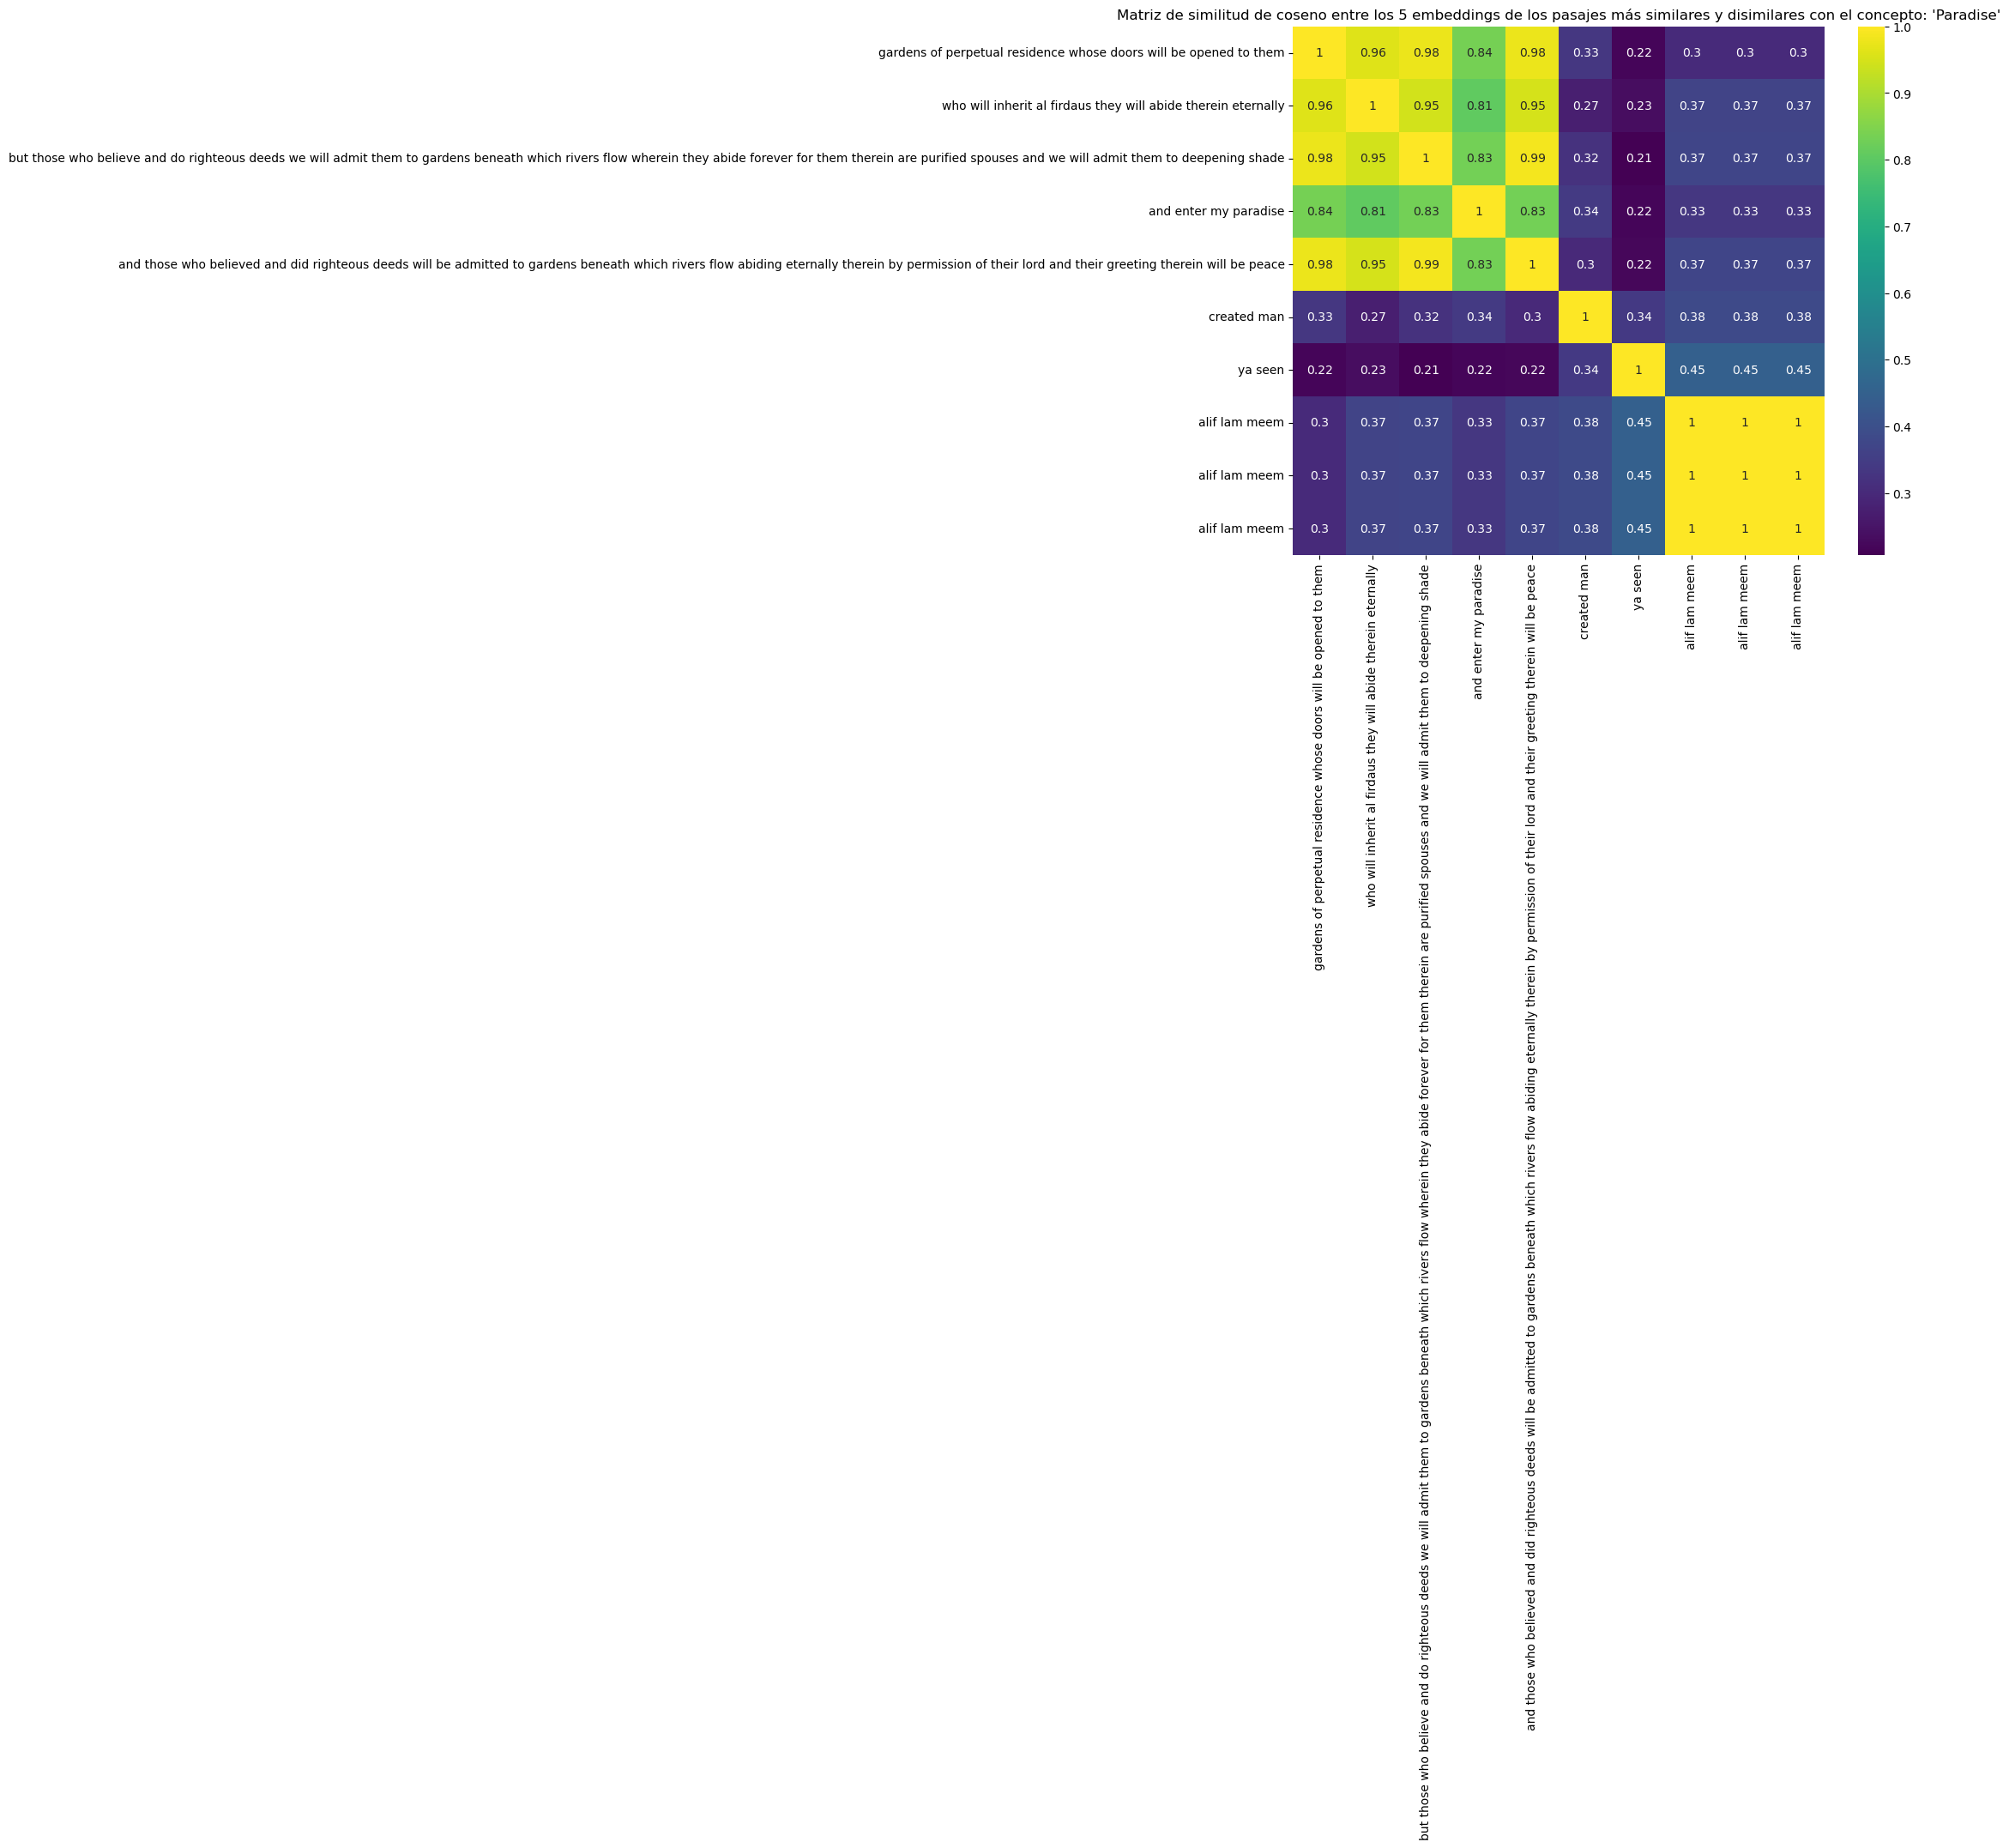

In [ ]:
similarity_matrix = np.vstack(df_concat["eng_embeddings"].values)
similarity_matrix = cosine_similarity(similarity_matrix)
textos = df_concat["text"].tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=textos, yticklabels=textos, cmap='viridis', annot=True)
plt.title(f"Matriz de similitud de coseno entre los 5 embeddings de los pasajes más similares y disimilares con el concepto: '{concepto}'")

## (Update Entrega 3)

## Clustering de capítulos con HDBSCAN
Para este nuevo apartado, usaremos el mismo modelo de embeddings usado anteriormente (fasttext) utilizaremos UMAP para la reducción de dimensionalidad. Ya que supuestamente funciona mejor para embeddings que el PCA (usado antes) y usaremos el modelo de clustering HDBSCAN para visualizar los grupos de capítulos más similares en un espacio bidimensional.

En árabe primero:

In [33]:
df_ft[["capitulo", "verso", "texto"]] = df_ft["text"].str.split("|", expand=True)
df_ft["capitulo"] = df_ft["capitulo"].astype(int)
df_ft["verso"] = df_ft["verso"].astype(int)
df_ft.drop(columns=["chapter", "verse", "text"], inplace=True)
# En este formato podremos agrupar los versos más fácilmente
df_ft.head()

,arab_embeddings,cos_similarity,ayah,capitulo,verso,texto
0,"[-0.019328587, -0.011044773, -0.015670374, -0....",-0.040109,بسم الله الرحمن الرحيم,1,1,بسم الله الرحمن الرحيم
1,"[-0.03869976, -0.04849257, -0.066881254, -0.02...",-0.073737,الحمد لله رب العالمين,1,2,الحمد لله رب العالمين
2,"[-0.027054688, -0.03456732, 0.055210564, 0.002...",-0.020870,الرحمن الرحيم,1,3,الرحمن الرحيم
3,"[-0.0029386058, 0.0030456535, -0.13178103, -0....",-0.048061,مالك يوم الدين,1,4,مالك يوم الدين
4,"[0.023694675, 0.017044265, -0.12696615, -0.052...",-0.076868,اياك نعبد واياك نستعين,1,5,اياك نعبد واياك نستعين


In [42]:
embeddings_cap_ar = (
    df_ft.groupby("capitulo")["arab_embeddings"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    .reset_index()
)
print(f"Dimensiones de nuestro df con los embeddings agrupados por capitulos: {embeddings_cap_ar.shape}")
# 114 capítulos (filas) y 2 columnas (número del capítulo y los embeddings agrupados)
print(embeddings_cap_ar.head(5))

Dimensiones de nuestro df con los embeddings agrupados por capitulos: (114, 2)
   capitulo                                    arab_embeddings
0         1  [-0.0018971954, -0.014747647, -0.05692218, -0....
1         2  [0.010936609, 0.017551364, -0.11662658, -0.037...
2         3  [0.010753912, 0.016165094, -0.11201501, -0.038...
3         4  [0.007213753, 0.014052949, -0.13082455, -0.035...
4         5  [0.012062487, 0.017264213, -0.11358402, -0.037...


In [48]:
# Ahora vamos a reducir su dimensionalidad con UMAP
X = np.vstack(embeddings_cap_ar["arab_embeddings"].values) # Stackeamos verticalmente los embeddings por capítulo
X_scaled = StandardScaler().fit_transform(X) # Y escalamos

umap_reducer = umap.UMAP(
    n_neighbors=5,
    min_dist=0.1, 
    n_components=10, # Lo dejaremos en 10 dimensiones para preservar mejor la información pero lo pasaremos a 2 después para una mejor visualización
    metric="cosine", # utilizaremos el cosine similarity como métrica de similitud
    random_state=42
)

X_umap = umap_reducer.fit_transform(X_scaled)

/home/unai/miniconda3/envs/coran-nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Agrupación con HDBSCAN

In [51]:
hdbscan_ar = hdbscan.HDBSCAN(
    min_cluster_size = 3, # tamaño mínimo del cluster
    metric = "euclidean", # distancia euclidiana
    cluster_selection_epsilon = 0.05,
    cluster_selection_method = "leaf"
)

labels = hdbscan_ar.fit_predict(X_umap) # Labels predecidos por
embeddings_cap_ar["cluster"] = labels

/home/unai/miniconda3/envs/coran-nlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/unai/miniconda3/envs/coran-nlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Mostramos los resultados:

/home/unai/miniconda3/envs/coran-nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


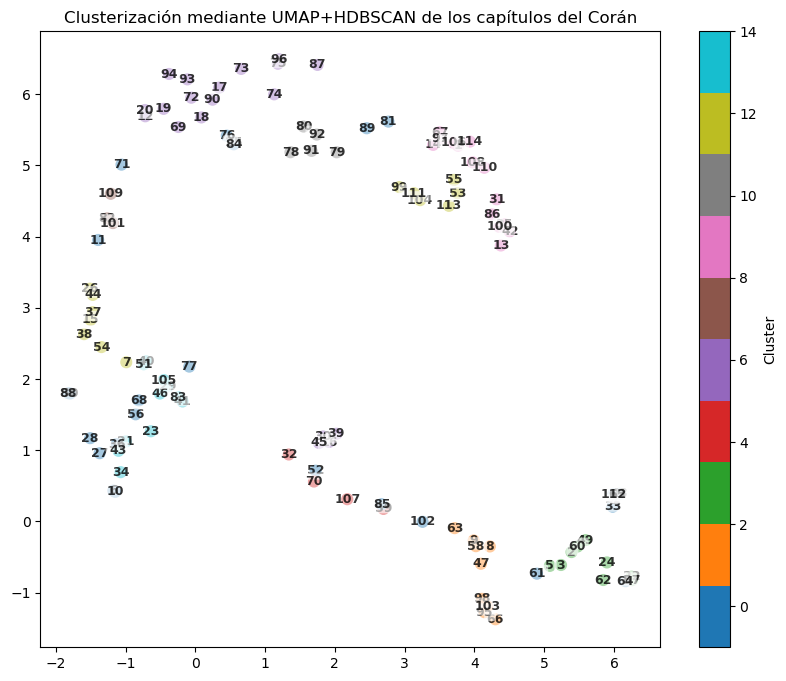

In [75]:
'''
for c in sorted(embeddings_cap_ar["cluster"].unique()):
    if c == -1: # No ha encontrado cluster el capítulo
        print(f"Capítulo sin cluster")
    for cl in embeddings_cap_ar["cluster"].unique():
        print(f"Cluster {cl}: {embeddings_cap_ar.loc[embeddings_cap_ar['cluster'] == cl, 'capitulo'].tolist()}")
'''
reducer_2d = umap.UMAP(
    n_neighbors=5, 
    min_dist=0.1, 
    n_components=2, # ahora sí lo pasamos a 2 dimensiones
    metric="cosine", 
    random_state=42
)
X_2D = reducer_2d.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
plt.scatter(X_2D[:,0], X_2D[:,1], c=labels, cmap="tab10", s=60)
for i, cap in enumerate(embeddings_cap_ar["capitulo"]):
    plt.text(
        X_2D[i, 0],
        X_2D[i, 1],
        str(cap),
        fontsize=9,
        fontweight='bold',
        ha='center',
        va='center',
        color='black',       # color del texto
        alpha=0.8,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
    )
plt.title("Clusterización mediante UMAP+HDBSCAN de los capítulos del Corán")
plt.colorbar(label="Cluster")
plt.show()